In [16]:
#https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e

In [17]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [18]:
import cv2
import extcolors

from colormap import rgb2hex

# For 1 image

In [30]:
image = "../images/WikiArt/Cubism/57726fb1edc2cb3880bb430d.jpg"
image

'../images/WikiArt/Cubism/57726fb1edc2cb3880bb430d.jpg'

In [31]:
colors_x = extcolors.extract_from_path(image, tolerance = 24, limit = 10)

In [32]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['hex_code','occurence'])
    return df

In [33]:
df_color = color_to_df(colors_x)

In [34]:
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    rgb = tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))
    return rgb

# Convertir códigos hexadecimales a valores RGB
df_color['R'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[0])
df_color['G'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[1])
df_color['B'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[2])

# Calcular el porcentaje de ocurrencia
df_color['occurence'] = df_color['occurence'].astype(int)
total_occurrence = df_color['occurence'].sum()
df_color['percent'] = (df_color['occurence'] / total_occurrence * 100).round(2)


df_color['Movement'] = 'Abstract-Art'

In [35]:
df_color

,hex_code,occurence,R,G,B,percent,Movement
0,#D6D4BF,309547,214,212,191,36.85,Abstract-Art
1,#0A0904,207367,10,9,4,24.68,Abstract-Art
2,#DFC070,87993,223,192,112,10.47,Abstract-Art
3,#46412B,78092,70,65,43,9.30,Abstract-Art
4,#EDB000,46115,237,176,0,5.49,Abstract-Art
5,#C80600,37670,200,6,0,4.48,Abstract-Art
6,#958C61,34965,149,140,97,4.16,Abstract-Art
7,#68AA52,21955,104,170,82,2.61,Abstract-Art
8,#CC6E00,16397,204,110,0,1.95,Abstract-Art


In [40]:
def exact_color(input_image, resize, tolerance, zoom):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    #resize
    output_width = resize
    img = Image.open(input_image)
    if img.size[0] >= resize:
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((output_width,hsize), Image.ANTIALIAS)
        resize_name = input_image
        img.save(resize_name)
    else:
        resize_name = input_image
    
    #crate dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 10)
    df_color = color_to_df(colors_x)
    
    #annotate text
    list_color = list(df_color['hex_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) <= 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+100, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+100, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    return plt.show()

/var/folders/d2/c8nbsrk920lgrdq2nn0mv1t00000gn/T/ipykernel_8265/149719164.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((output_width,hsize), Image.ANTIALIAS)


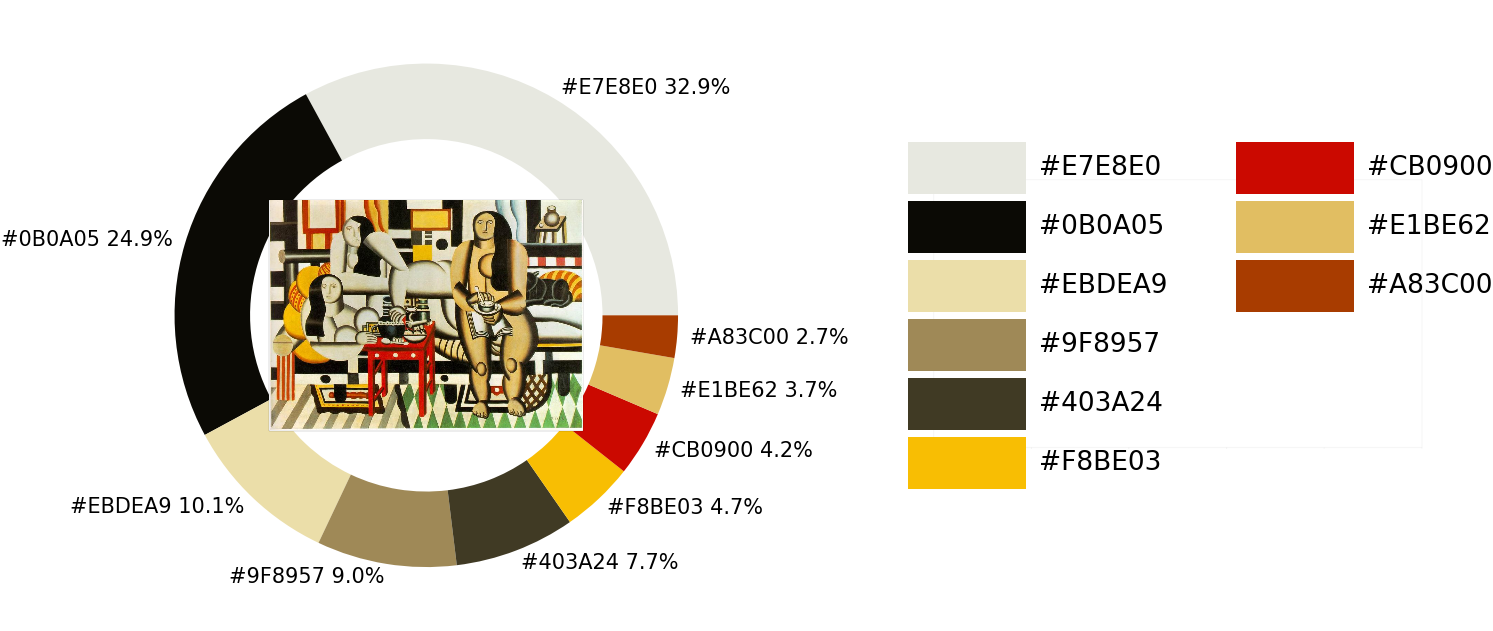

In [41]:
exact_color(image, 900, 24, 2.5)

# For 1 folder

In [189]:
def color_to_df(input):
    
    """
    This function performs the conversion of data obtained from an image 
    in RGB colors to hexadecimal codes and creates a df.
    """
    
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1] # divides the input data into a list of tuples
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list] #RGB values are extracted
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list] #the occurrence values are extracted
    
    # RGB to HEX code conversion
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns=['hex_code', 'occurence'])
    return df

In [190]:
def hex_to_rgb(hex_code):
    """
    This function takes a hexadecimal color code as input, 
    strips the '#' character, and converts the code to its RGB representation
    """
    hex_code = hex_code.lstrip('#')
    rgb = tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))
    return rgb

In [191]:
movement = "Abstract-Expressionism"

In [192]:
folder_path = f"../images/WikiArt/{movement}"
df_list = []

In [193]:
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        colors_x = extcolors.extract_from_path(image_path, tolerance=24, limit=10)
        df_color = color_to_df(colors_x)
        df_color['R'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[0])
        df_color['G'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[1])
        df_color['B'] = df_color['hex_code'].apply(lambda x: hex_to_rgb(x)[2])
        df_color['occurence'] = df_color['occurence'].astype(int)
        total_occurrence = df_color['occurence'].sum()
        df_color['percent'] = (df_color['occurence'] / total_occurrence * 100).round(2)
        df_color['Movement'] = movement
        df_list.append(df_color)

__TOP 10__

In [194]:
df = pd.concat(df_list, ignore_index=True) # Abstract-Art
df.to_csv(f'../data/palettes/Movement/{movement}_palette.csv', index=False)
df

,hex_code,occurence,R,G,B,percent,Movement
0,#2A2829,713186,42,40,41,96.94,Abstract-Expressionism
1,#654121,20824,101,65,33,2.83,Abstract-Expressionism
2,#987E4B,1676,152,126,75,0.23,Abstract-Expressionism
3,#D6C086,47,214,192,134,0.01,Abstract-Expressionism
4,#B0A577,181733,176,165,119,99.38,Abstract-Expressionism
...,...,...,...,...,...,...,...
1516,#AE8C80,129669,174,140,128,80.31,Abstract-Expressionism
1517,#6C504D,18994,108,80,77,11.76,Abstract-Expressionism
1518,#190D11,10003,25,13,17,6.20,Abstract-Expressionism
1519,#FFF4ED,2777,255,244,237,1.72,Abstract-Expressionism


In [195]:
grouped_df = df.groupby('hex_code').sum('occurence').reset_index()

In [196]:
grouped_df = grouped_df[~grouped_df['hex_code'].isin(['#000000', '#FFFFFF'])]

In [197]:
grouped_df

,hex_code,occurence,R,G,B,percent
1,#000002,30432,0,0,2,13.75
2,#000005,4906,0,0,5,3.09
3,#000030,731406,0,0,48,33.80
4,#000037,2881,0,0,55,0.57
5,#000039,6518,0,0,57,0.40
...,...,...,...,...,...,...
1464,#FFFFF0,3520,255,255,240,1.83
1465,#FFFFF4,626,255,255,244,0.22
1466,#FFFFF6,18061,255,255,246,5.42
1467,#FFFFFB,342,255,255,251,0.15


In [198]:
sorted_df = grouped_df.sort_values('occurence', ascending=False)

In [199]:
top_10_colors = sorted_df.head(10)

In [200]:
top_10_colors['Movement'] = movement

/var/folders/d2/c8nbsrk920lgrdq2nn0mv1t00000gn/T/ipykernel_55858/909104118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_colors['Movement'] = movement


In [201]:
top_10_colors

,hex_code,occurence,R,G,B,percent,Movement
8,#000078,1551349,0,0,120,89.55,Abstract-Expressionism
781,#958E7B,1363732,149,142,123,88.52,Abstract-Expressionism
1286,#E0E0DE,1336087,224,224,222,91.96,Abstract-Expressionism
1407,#F7F7F7,1308463,247,247,247,60.70,Abstract-Expressionism
327,#47596D,1260457,71,89,109,58.24,Abstract-Expressionism
1453,#FFFBF5,1243049,255,251,245,75.00,Abstract-Expressionism
1425,#FDDA5A,1011667,253,218,90,69.81,Abstract-Expressionism
1449,#FFF1D4,937994,255,241,212,41.34,Abstract-Expressionism
896,#A76A3D,898284,167,106,61,71.36,Abstract-Expressionism
1400,#F6F8F5,831039,246,248,245,47.24,Abstract-Expressionism


In [202]:
top_10_colors.to_csv(f'../data/palettes/Movement/{movement}_palette_top10.csv', index=False)

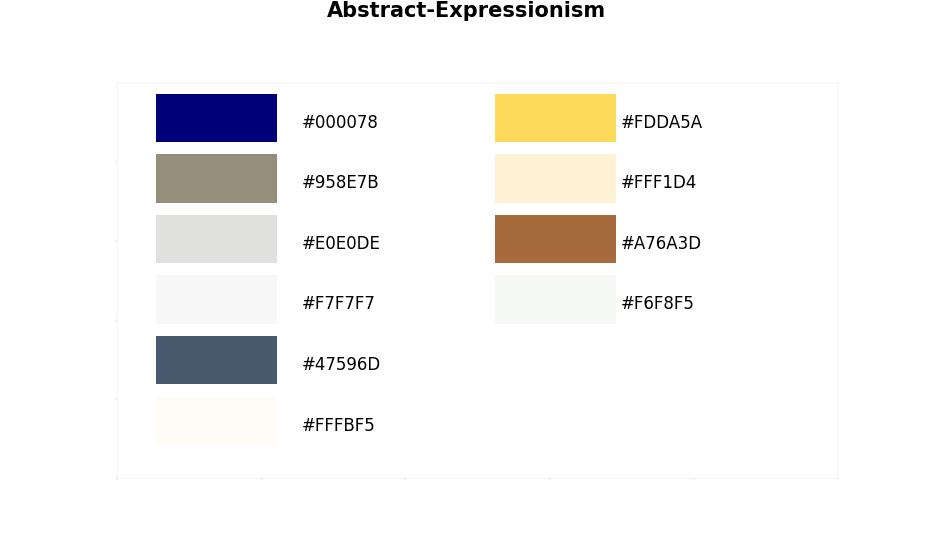

In [203]:
bg = plt.imread('bg.png')
fig = plt.figure(figsize=(120, 120), dpi=10)
ax = fig.add_subplot(1, 1, 1)

x_posi, y_posi, y_posi2 = 320, 25, 25
for color in top_10_colors['hex_code'].tolist():
    if top_10_colors['hex_code'].tolist().index(color) <= 5:
        y_posi += 125
        rect = patches.Rectangle((x_posi, y_posi), 250, 100, facecolor=color)
        ax.add_patch(rect)
        ax.text(x=x_posi + 300, y=y_posi + 70, s=color, fontdict={'fontsize': 120})
    else:
        y_posi2 += 125
        rect = patches.Rectangle((x_posi + 700, y_posi2), 250, 100, facecolor=color)
        ax.add_artist(rect)
        ax.text(x=x_posi + 960, y=y_posi2 + 70, s=color, fontdict={'fontsize': 120})

plt.title(top_10_colors['Movement'].iloc[0], fontsize=150, fontweight='bold')
ax.axis('off')

plt.imshow(bg)

#plt.savefig(f"../images/palettes/Movement/{movement}_palette.png", dpi=300, bbox_inches='tight')
plt.show()


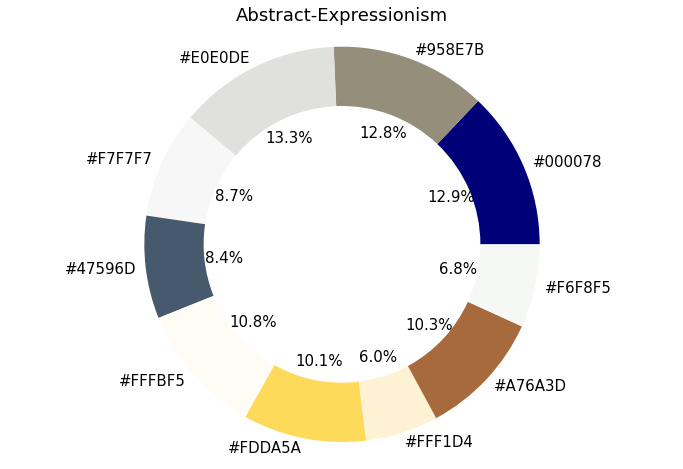

In [204]:
fig, ax1 = plt.subplots(figsize=(12, 8))
wedges, text, autotexts = ax1.pie(top_10_colors['percent'],
                                  labels=top_10_colors['hex_code'],
                                  labeldistance=1.05,
                                  colors=top_10_colors['hex_code'],
                                  autopct='%1.1f%%',
                                  textprops={'fontsize': 15, 'color': 'black'})

plt.setp(wedges, width=0.3)
ax1.set_title(top_10_colors['Movement'].iloc[0], fontsize=18)
ax1.axis('equal')
fig.set_facecolor('white')
plt.savefig(f"../images/palettes/Movement/{movement}_palette_donut.png", dpi=300)
plt.show()


In [188]:
! ls ../data/palettes/Movement/

Abstract-Art_palette.csv
Abstract-Art_palette_top10.csv
Abstract-Expressionism_palette.csv
Abstract-Expressionism_palette_top10.csv
Art-Informel_palette.csv
Art-Informel_palette_top10.csv
Baroque_palette.csv
Baroque_palette_top10.csv
Color-Field-Painting_palette.csv
Color-Field-Painting_palette_top10.csv
Cubism_palette.csv
Cubism_palette_top10.csv
Early-Renaissance_palette.csv
Early-Renaissance_palette_top10.csv
Expressionism_palette.csv
Expressionism_palette_top10.csv
High-Renaissance_palette.csv
High-Renaissance_palette_top10.csv
Impressionism_palette.csv
Impressionism_palette_top10.csv
Lyrical-Abstraction_palette.csv
Lyrical-Abstraction_palette_top10.csv
Magic-Realism_palette.csv
Magic-Realism_palette_top10.csv
Minimalism_palette.csv
Minimalism_palette_top10.csv
Neo-Expressionism_palette.csv
Neo-Expressionism_palette_top10.csv
Neoclassicism_palette.csv
Neoclassicism_palette_top10.csv
Northern-Renaissance_palette.csv
Northern-Renaissance_palette_top10.csv
Pop-Art_palette.csv
Pop-Art_